In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [43]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-prokofev/RFM_ht_data.csv', parse_dates=['InvoiceDate'])

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
df.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [76]:
df.InvoiceNo = df.InvoiceNo.astype('str')
df.CustomerCode = df.CustomerCode.astype('str')

In [77]:
df.dtypes

InvoiceNo               object
CustomerCode            object
InvoiceDate     datetime64[ns]
Amount                 float64
dtype: object

In [78]:
df.shape

(332730, 4)

In [79]:
# RFM analysis
final_date = df.InvoiceDate.max()
print(final_date)

2020-09-30 00:00:00


In [80]:
rfm = df.groupby('CustomerCode', as_index=False) \
    .agg({'InvoiceDate': lambda x: (final_date - x.max()).days,
        'InvoiceNo': lambda x: len(x),
        'Amount': lambda x: x.sum()})
rfm

,CustomerCode,InvoiceDate,InvoiceNo,Amount
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


In [81]:
rfm.InvoiceDate = rfm.InvoiceDate.astype('int')
rfm = rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Amount': 'Monetary'})
rfm.head()

,CustomerCode,Recency,Frequency,Monetary
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88


In [82]:
print(rfm.shape[0], df.CustomerCode.nunique()) #проверка

123733 123733


In [83]:
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75]) #Получили границы разбиения на группы для каждого из параметров RFM
quantiles

,Recency,Frequency,Monetary
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [84]:
def Recency_converter(value, parameter, quantiles_table):
    if value <= quantiles_table[parameter][0.25]:
        return 1
    elif quantiles_table[parameter][0.50] >= value > quantiles_table[parameter][0.25]:
        return 2
    elif quantiles_table[parameter][0.75] >= value > quantiles_table[parameter][0.50]:
        return 3
    elif value > quantiles_table[parameter][0.75]:
        return 4
    
def Fr_and_Mo_converter(value, parameter, quantiles_table):
    if value <= quantiles_table[parameter][0.25]:
        return 4
    elif quantiles_table[parameter][0.50] >= value > quantiles_table[parameter][0.25]:
        return 3
    elif quantiles_table[parameter][0.75] >= value > quantiles_table[parameter][0.50]:
        return 2
    elif value > quantiles_table[parameter][0.75]:
        return 1

In [85]:
rfm['Recency_Class'] = rfm['Recency'].apply(Recency_converter, args=('Recency', quantiles))
rfm['Frequency_Class'] = rfm['Frequency'].apply(Fr_and_Mo_converter, args=('Frequency', quantiles))
rfm['Monetary_Class'] = rfm['Monetary'].apply(Fr_and_Mo_converter, args=('Monetary', quantiles))

In [86]:
rfm['RFM_Class'] = rfm['Recency_Class'].map(str) + rfm['Frequency_Class'].map(str) + rfm['Monetary_Class'].map(str)
rfm.head()

,CustomerCode,Recency,Frequency,Monetary,Recency_Class,Frequency_Class,Monetary_Class,RFM_Class
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443


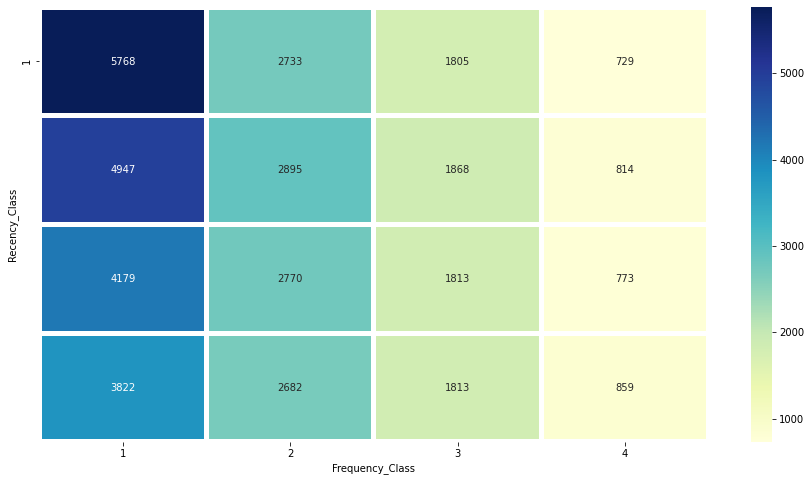

In [87]:
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['image.cmap'] = 'viridis'
viz = rfm.pivot_table(
    index='Recency_Class',
    columns='Frequency_Class',
    values='Monetary',
    aggfunc=np.median).applymap(int)
sns.heatmap(viz, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=4.15, annot_kws={'size': 10}, yticklabels=4)

In [88]:
# Task 2 - какое максимальное количество покупок было совершено одним пользователем
df.groupby('CustomerCode', as_index=False) \
    .agg({'Amount': 'count'}) \
    .sort_values('Amount', ascending=False) \
    .head()

,CustomerCode,Amount
89388,19057820,204
44594,13215452,113
10347,13032521,106
97077,19080880,99
119951,99003061,90


In [89]:
# Task 3 - Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? 
# (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)

rfm.query('Monetary_Class == 4').Monetary.max()

765.0

In [103]:
# Task 4 -Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?
rfm.query('Frequency_Class == 1').Frequency.min()

4

In [91]:
# Task 5 - Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь
# попал в класс 2 в подсегменте R?
quantiles

,Recency,Frequency,Monetary
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [93]:
# Task 6 - Сколько пользователей попало в сегмент 111?
rfm.query('Monetary_Class == 1 and Recency_Class == 1 and Frequency_Class == 1').shape[0]

9705

In [95]:
# Task 7 - Сколько пользователей попало в сегмент 311?
rfm.query('Monetary_Class == 1 and Recency_Class == 3 and Frequency_Class == 1').shape[0]

1609

In [101]:
# Task 8 - В каком RFM-сегменте самое большое кол-во пользователей?
rfm.groupby('RFM_Class', as_index=False) \
    .agg({'CustomerCode': 'count'}) \
    .sort_values('CustomerCode', ascending = False) \
    .head(1)

,RFM_Class,CustomerCode
63,444,10624


In [102]:
# Task 9 - В каком RFM-сегменте самое маленькое кол-во пользователей?
# Task 10 - Какое количество пользователей попало в самый малочисленный сегмент?
rfm.groupby('RFM_Class', as_index=False) \
    .agg({'CustomerCode': 'count'}) \
    .sort_values('CustomerCode', ascending = True) \
    .head(1)

,RFM_Class,CustomerCode
51,414,2
